<a href="https://colab.research.google.com/github/gabilodeau/INF6804/blob/master/Flux_optique_avec_MMFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INF6804 Vision par ordinateur
Polytechnique Montréal <br>
Auteur : Mehdi Miah

Description : ce Jupyter notebook implémente un algorithme de flux optique. L'entrée est une paire d'images et la sortie est une carte de flux optique (direction et vitesse du mouvement pour chaque pixel). Ce notebook repose sur la librairie MMFlow du MMLab.

## Installation des librairies


In [1]:
# Previous version of torch : for mmcv compatibility
%pip install torch==1.11.0+cu102 torchvision==0.12.0+cu102 --extra-index-url https://download.pytorch.org/whl/cu102

# MMCV (OpenMMLab Computer Vision Foundation)
%pip install mmcv-full==1.6.0 -f https://download.openmmlab.com/mmcv/dist/cu102/torch1.11/index.html

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu102
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 94.6 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.4.0+cu121
    Uninstalling torch-2.4.0+cu121:
      Successfully uninstalled torch-2.4.0+cu121
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.19.0+cu121
    Uninstalling torchvision-0.19.0+cu121:
      Successfully uninstalled torchvision-0.19.0+cu121
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.4.0+cu121 requires torch==2.4.0, but you have torch 1.11.0+cu102 which is incompatible.
Looking in links: https://download.openmmlab.com/mmcv/dist/cu102/torch1.11/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# MMFlow
!git clone https://github.com/open-mmlab/mmflow.git  # 0.5.2, commit 9fb1d2f
%cd mmflow
!pip install -e .

Cloning into 'mmflow'...
remote: Enumerating objects: 3684, done.
remote: Counting objects: 100% (251/251), done.
remote: Compressing objects: 100% (179/179), done.
remote: Total 3684 (delta 97), reused 173 (delta 51), pack-reused 3433 (from 1)
Receiving objects: 100% (3684/3684), 22.23 MiB | 12.38 MiB/s, done.
Resolving deltas: 100% (2230/2230), done.
/content/mmflow
Obtaining file:///content/mmflow
  Preparing metadata (setup.py) ... done
  Running setup.py develop for mmflow


In [3]:
# Install libssl from OpenSSL to make mmflow works:
  # Without this patch, we get the following error:
    # ImportError: libssl.so.1.1: cannot open shared object file: No such file or directory
  # Solution : https://stackoverflow.com/questions/72133316/libssl-so-1-1-cannot-open-shared-object-file-no-such-file-or-directory
  # Need to update the link of the file in case of expired link
!wget http://nz2.archive.ubuntu.com/ubuntu/pool/main/o/openssl/libssl1.1_1.1.1f-1ubuntu2.23_amd64.deb -P /content/
!sudo dpkg -i /content/libssl1.1_1.1.1f-1ubuntu2.23_amd64.deb

from mmflow.apis import init_model, inference_model
from mmflow.datasets import visualize_flow

from time import time

--2024-09-18 15:28:48--  http://nz2.archive.ubuntu.com/ubuntu/pool/main/o/openssl/libssl1.1_1.1.1f-1ubuntu2.23_amd64.deb
Resolving nz2.archive.ubuntu.com (nz2.archive.ubuntu.com)... 185.125.190.81, 185.125.190.83, 91.189.91.82, ...
Connecting to nz2.archive.ubuntu.com (nz2.archive.ubuntu.com)|185.125.190.81|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1323104 (1.3M) [application/vnd.debian.binary-package]
Saving to: ‘/content/libssl1.1_1.1.1f-1ubuntu2.23_amd64.deb’

libssl1.1_1.1.1f-1u 100%[===================>]   1.26M  1.09MB/s    in 1.2s    

2024-09-18 15:28:50 (1.09 MB/s) - ‘/content/libssl1.1_1.1.1f-1ubuntu2.23_amd64.deb’ saved [1323104/1323104]

Selecting previously unselected package libssl1.1:amd64.
(Reading database ... 123599 files and directories currently installed.)
Preparing to unpack .../libssl1.1_1.1.1f-1ubuntu2.23_amd64.deb ...
Unpacking libssl1.1:amd64 (1.1.1f-1ubuntu2.23) ...
Setting up libssl1.1:amd64 (1.1.1f-1ubuntu2.23) ...
debconf: un

## Téléchargement de paires d'images

In [4]:
import os
import cv2
import matplotlib.pyplot as plt

# Image pairs
img1_name, img2_name = 'in000235.jpg', 'in000240.jpg'
img1_path = os.path.join('/content', img1_name)
img2_path = os.path.join('/content', img2_name)

# Download images
if not os.path.exists(img1_path):
  !gdown https://raw.githubusercontent.com/gabilodeau/INF6804/master/images/$img1_name -O $img1_path
if not os.path.exists(img2_path):
  !gdown https://raw.githubusercontent.com/gabilodeau/INF6804/master/images/$img2_name -O $img2_path


Downloading...
From: https://raw.githubusercontent.com/gabilodeau/INF6804/master/images/in000235.jpg
To: /content/in000235.jpg
100% 177k/177k [00:00<00:00, 35.2MB/s]
Downloading...
From: https://raw.githubusercontent.com/gabilodeau/INF6804/master/images/in000240.jpg
To: /content/in000240.jpg
100% 177k/177k [00:00<00:00, 54.3MB/s]


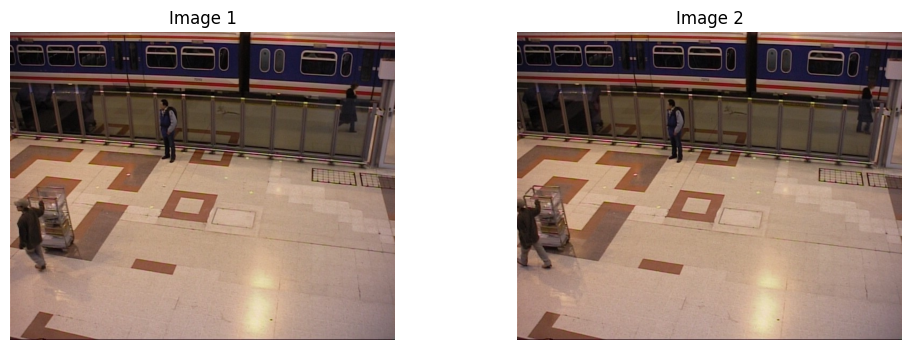

In [5]:
# Visualization of the image pairs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Read images with OpenCV as BGR
image1 = cv2.imread(img1_path)
image2 = cv2.imread(img2_path)

# Conversion BGR -> RGB
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

# Matplotlib displays images as RGB
ax1.imshow(image1)
ax2.imshow(image2)

ax1.set_title('Image 1')
ax2.set_title('Image 2')
ax1.axis('off')
ax2.axis('off')

plt.show()

## Inférences avec plusieurs modèles de flux optique
Cinq modèles sont proposés dans ce notebook (voir références pour plus d'infos) :
- FlowNet ([FlowNet: Learning Optical Flow with Convolutional Networks](https://www.cv-foundation.org/openaccess/content_iccv_2015/papers/Dosovitskiy_FlowNet_Learning_Optical_ICCV_2015_paper.pdf), ICCV 2015) ;
- FlowNet2 ([FlowNet 2.0: Evolution of Optical Flow Estimation with Deep Networks](https://openaccess.thecvf.com/content_cvpr_2017/papers/Ilg_FlowNet_2.0_Evolution_CVPR_2017_paper.pdf), CVPR 2017) ;
- PWC-Net ([PWC-Net: CNNs for Optical Flow Using Pyramid, Warping, and Cost Volume](https://openaccess.thecvf.com/content_cvpr_2018/papers/Sun_PWC-Net_CNNs_for_CVPR_2018_paper.pdf), CVPR 2018) ;
- RAFT ([RAFT: Recurrent All-Pairs Field Transforms for
Optical Flow](https://www.ecva.net/papers/eccv_2020/papers_ECCV/papers/123470392.pdf), ECCV 2020) ;
- GMA ([Learning to Estimate Hidden Motions with Global Motion Aggregation](https://openaccess.thecvf.com/content/ICCV2021/papers/Jiang_Learning_To_Estimate_Hidden_Motions_With_Global_Motion_Aggregation_ICCV_2021_paper.pdf), ICCV 2021)

In [6]:
# Dictionnary of some models
dict_model = {'FlowNet': {'config_file': '/content/mmflow/configs/flownet/flownetc_8x1_sfine_sintel_384x448.py',
                          'checkpoint_file': 'https://download.openmmlab.com/mmflow/flownet/flownetc_8x1_sfine_sintel_384x448.pth'},

              'FlowNet2': {'config_file': '/content/mmflow/configs/flownet2/flownet2_8x1_sfine_flyingthings3d_subset_384x768.py',
                           'checkpoint_file': 'https://download.openmmlab.com/mmflow/flownet2/flownet2_8x1_sfine_flyingthings3d_subset_384x768.pth'},

              'PWCNet': {'config_file': '/content/mmflow/configs/pwcnet/pwcnet_8x1_slong_flyingchairs_384x448.py',
                         'checkpoint_file': 'https://download.openmmlab.com/mmflow/pwcnet/pwcnet_8x1_slong_flyingchairs_384x448.pth'},

              'RAFT': {'config_file': '/content/mmflow/configs/raft/raft_8x2_100k_mixed_368x768.py',
                       'checkpoint_file': 'https://download.openmmlab.com/mmflow/raft/raft_8x2_100k_mixed_368x768.pth'},

              'GMA': {'config_file': '/content/mmflow/configs/gma/gma_8x2_120k_mixed_368x768.py',
                       'checkpoint_file': 'https://download.openmmlab.com/mmflow/gma/gma_p-only_8x2_120k_mixed_368x768.pth'}}

In [7]:
# Inference with every model
execution_time = {}

for model_name in dict_model:

  # Loads the model
  model = init_model(config=dict_model[model_name]['config_file'],
                     checkpoint=dict_model[model_name]['checkpoint_file'],
                     device='cuda:0')

  # Inference
  tic = time()
  result = inference_model(model, img1_path, img2_path)
  execution_time[model_name] = time()-tic

  # Save the flow map as an image
  flow_map = visualize_flow(result, save_file=f'flow_map_{model_name}.png')

load checkpoint from http path: https://download.openmmlab.com/mmflow/flownet/flownetc_8x1_sfine_sintel_384x448.pth


Downloading: "https://download.openmmlab.com/mmflow/flownet/flownetc_8x1_sfine_sintel_384x448.pth" to /root/.cache/torch/hub/checkpoints/flownetc_8x1_sfine_sintel_384x448.pth


  0%|          | 0.00/448M [00:00<?, ?B/s]

2024-09-18 15:29:26,972 - mmflow - INFO - Freeze the parameters in FlowNetCSS
2024-09-18 15:29:29,207 - mmflow - INFO - Freeze the parameters in FlowNetS


load checkpoint from http path: https://download.openmmlab.com/mmflow/flownet2/flownet2_8x1_sfine_flyingthings3d_subset_384x768.pth


Downloading: "https://download.openmmlab.com/mmflow/flownet2/flownet2_8x1_sfine_flyingthings3d_subset_384x768.pth" to /root/.cache/torch/hub/checkpoints/flownet2_8x1_sfine_flyingthings3d_subset_384x768.pth


  0%|          | 0.00/1.82G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


load checkpoint from http path: https://download.openmmlab.com/mmflow/pwcnet/pwcnet_8x1_slong_flyingchairs_384x448.pth


Downloading: "https://download.openmmlab.com/mmflow/pwcnet/pwcnet_8x1_slong_flyingchairs_384x448.pth" to /root/.cache/torch/hub/checkpoints/pwcnet_8x1_slong_flyingchairs_384x448.pth


  0%|          | 0.00/107M [00:00<?, ?B/s]

load checkpoint from http path: https://download.openmmlab.com/mmflow/raft/raft_8x2_100k_mixed_368x768.pth


Downloading: "https://download.openmmlab.com/mmflow/raft/raft_8x2_100k_mixed_368x768.pth" to /root/.cache/torch/hub/checkpoints/raft_8x2_100k_mixed_368x768.pth


  0%|          | 0.00/60.4M [00:00<?, ?B/s]

load checkpoint from http path: https://download.openmmlab.com/mmflow/gma/gma_p-only_8x2_120k_mixed_368x768.pth


Downloading: "https://download.openmmlab.com/mmflow/gma/gma_p-only_8x2_120k_mixed_368x768.pth" to /root/.cache/torch/hub/checkpoints/gma_p-only_8x2_120k_mixed_368x768.pth


  0%|          | 0.00/67.7M [00:00<?, ?B/s]

The model and loaded state dict do not match exactly

unexpected key in source state_dict: decoder.attn.pos_emb.rel_ind, decoder.attn.pos_emb.rel_height.weight, decoder.attn.pos_emb.rel_width.weight



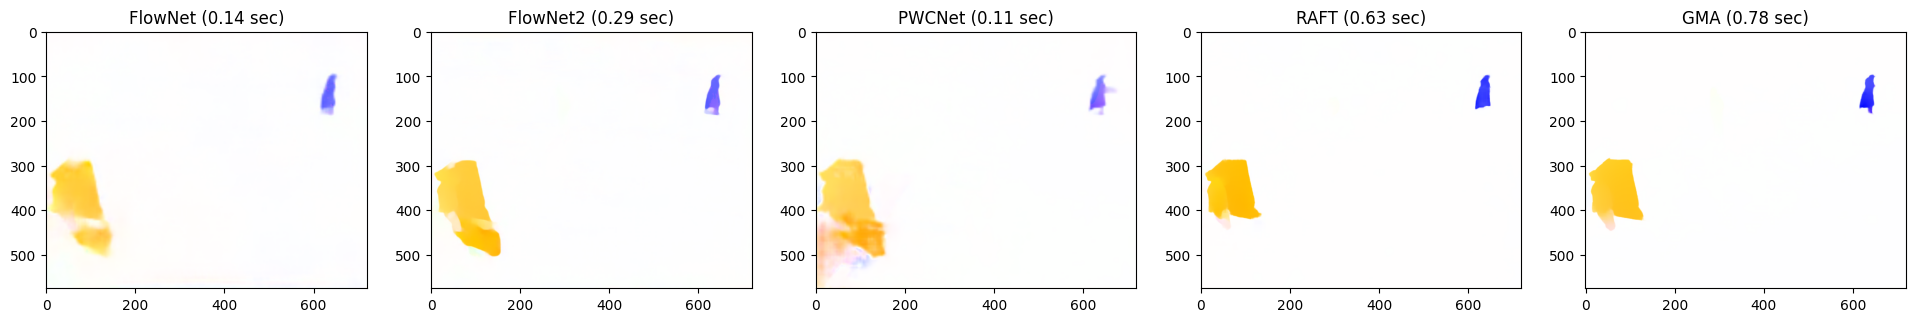

In [8]:
# Visualization of the flow maps
fig, axes = plt.subplots(1, len(dict_model), figsize=(24, 12))

for i, model_name in enumerate(dict_model.keys()):

  flowmap = cv2.imread(f'flow_map_{model_name}.png')
  axes[i].imshow(flowmap)
  axes[i].set_title(f"{model_name} ({execution_time[model_name]:0.2f} sec)")

plt.show()


## Références

Librairie MMFlow : https://github.com/open-mmlab/mmflow/ <br>
Model Zoo : https://github.com/open-mmlab/mmflow/blob/master/docs/en/model_zoo.md